<img src='images/pic1.jpg'/>

In [1]:
import sys
sys.path.insert(0,'C:\\Users\\nrtsa\\AppData\\Local\\Programs\\Python\\Python37\\Lib\\site-packages')

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [3]:
# Creating db file from csv 

if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    
    for df in pd.read_csv('Train.csv', names = ['Id','Title','Body','Tags'], chunksize = chunksize, iterator = True, encoding = 'utf-8'):
        df.index += index_start
        j += 1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists = 'append')
        index_start = df.index[-1]+1
    print("Time taken to run this cell: ", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell:  0:02:45.179859


<h3> 3.1.2 Counting the number of rows </h3>

In [4]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT Count(*) FROM data""", con)
    print("Number of rows in the database: ", num_rows['Count(*)'].values[0])
    # Always remember to close the databse
    con.close()
    print("Time taken to count the number of rows: ", datetime.now()-start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")                           
                                 

Number of rows in the database:  6034196
Time taken to count the number of rows:  0:00:00.809400


<h3>3.1.3 Checking for duplicates </h3>

In [5]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query("""SELECT Title, Body, Tags, Count(*) as cnt_dup FROM data GROUP BY Title, Body, Tags""", con)
    con.close()
    print("TIme taken to run this cell: ", datetime.now() - start)

else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")
    

TIme taken to run this cell:  0:03:52.561985


In [6]:
df_no_dup.sample(5)

,Title,Body,Tags,cnt_dup
2207336,Methods for determining acoustical similarity ...,<p>I'm looking for methods that work in practi...,music similarity mfcc playlists,1
1908013,Is it realistic to ask your team to take on a ...,<p>In a financial services environment - is it...,team test-coverage goals,2
3833677,iOS silver UI elements,<p>Is there any Apple-provided way to create U...,iphone ios ipad user-interface,1
1925595,"Is there a list of ""breaking changes"" (i.e. wh...",<p>Is there a list somewhere that lays out all...,workflow-foundation-4 workflowservice,2
2304889,Need to tweek my FTS4 SQLite query,<p>the query below doesn't work on Android and...,android sql sqlite full-text-search fts4,1


In [7]:
print("number of duplicate questions :", num_rows['Count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['Count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [8]:
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [9]:
# Drop the null values
df_no_dup = df_no_dup.dropna()
df_no_dup.shape

(4206308, 4)

In [10]:
# Add the New Column tag_count that shows the number of tags for each question
start = datetime.now()
df_no_dup['tag_count'] = df_no_dup['Tags'].apply(lambda text: len(text.split(" ")))
print("Time taken to run this cell: ",datetime.now() - start)
df_no_dup.head()


Time taken to run this cell:  0:00:02.531685


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [11]:
df_no_dup['tag_count'].value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

In [12]:
# Creating a new Database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_no_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns = ['Title','Body','Tags'])
    no_dup.to_sql('no_dup_train',disk_no_dup)

In [13]:
# Creating with the connection with the database file(train_no_dup)
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()
    
    # Now drop unwanted column
    tag_data.drop(tag_data.index[0], inplace = True)
    print(tag_data.head())
    print('Time taken to run this cell: ', datetime.now()-start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

                                  Tags
1          c# silverlight data-binding
2  c# silverlight data-binding columns
3                             jsp jstl
4                            java jdbc
5        facebook api facebook-php-sdk
Time taken to run this cell:  0:00:17.723301


<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [14]:
# Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool.

vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_vec = vectorizer.fit_transform(tag_data['Tags'])

In [15]:
print("Number of data points :", tag_vec.shape[0])
print("Number of unique tags :", tag_vec.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [16]:
tags = vectorizer.get_feature_names()
print("Some of the tags we havs: ", tags[:10])

Some of the tags we havs:  ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 3.2.3 Number of times a tag appeared </h3>


In [17]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freq = tag_vec.sum(axis=0).A1
result = dict(zip(tags,freq))

In [18]:
# Saving this dictionary into csv file
if not os.path.isfile('tag_counts_dict.csv'):
    with open('tag_counts_dict.csv','w') as csv_file:
        writer = csv.writer(csv_file)
        for key,value in result.items():
            writer.writerow([key,value])
tag_df = pd.read_csv('tag_counts_dict.csv', names = ['Tags','Counts'])
tag_df.head()
            

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [19]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending = False)
tag_counts = tag_df_sorted['Counts'].values

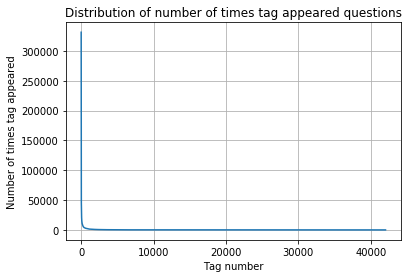

In [20]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

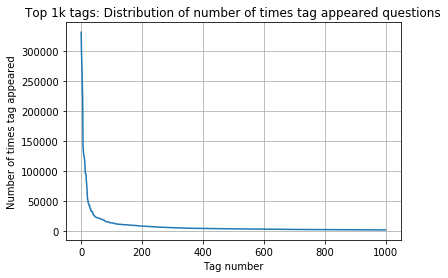

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [21]:
plt.plot(tag_counts[0:1000])
plt.title('Top 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

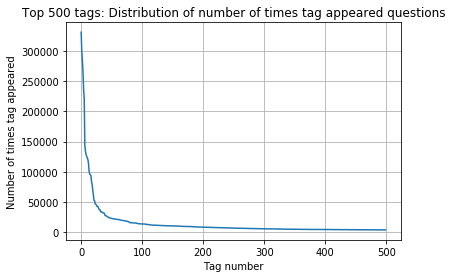

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [22]:
plt.plot(tag_counts[0:500])
plt.title('Top 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])


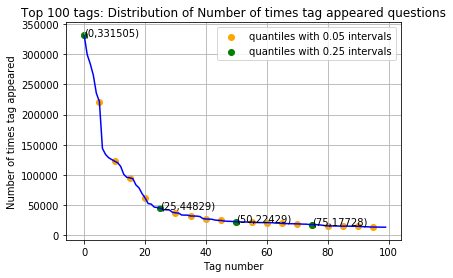

In [23]:

plt.plot(tag_counts[0:100], c = 'b')
plt.scatter(x=list(range(0,100,5)), y = tag_counts[0:100:5], c = 'orange', label = 'quantiles with 0.05 intervals')
plt.scatter(x = list(range(0,100,25)), y = tag_counts[0:100:25], c = 'green', label = 'quantiles with 0.25 intervals')
# https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.annotate.html
for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({},{})".format(x,y), xy=(x,y))

plt.title('Top 100 tags: Distribution of Number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [24]:
# Storing Tags greater than 10k in one list
tags_cnt_gt_10k = tag_df[tag_df.Counts > 10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(tags_cnt_gt_10k)))
# Store tags greater than 100K in one list
tags_cnt_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(tags_cnt_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

In [25]:
tags_count = list(tag_vec.sum(axis=1).A1)
print("Maximum number of tags per question: ",max(tags_count))
print("Minimun number of tags per question: ",min(tags_count))
print("Average number of tags per question: ", sum(tags_count)/len(tags_count))

Maximum number of tags per question:  5
Minimun number of tags per question:  1
Average number of tags per question:  2.899442670256831


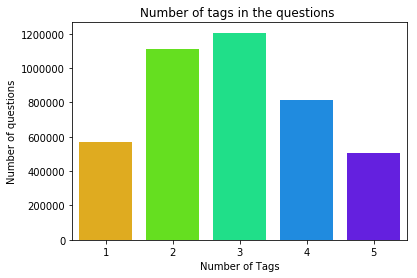

In [26]:
sns.countplot(tags_count, palette = 'gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

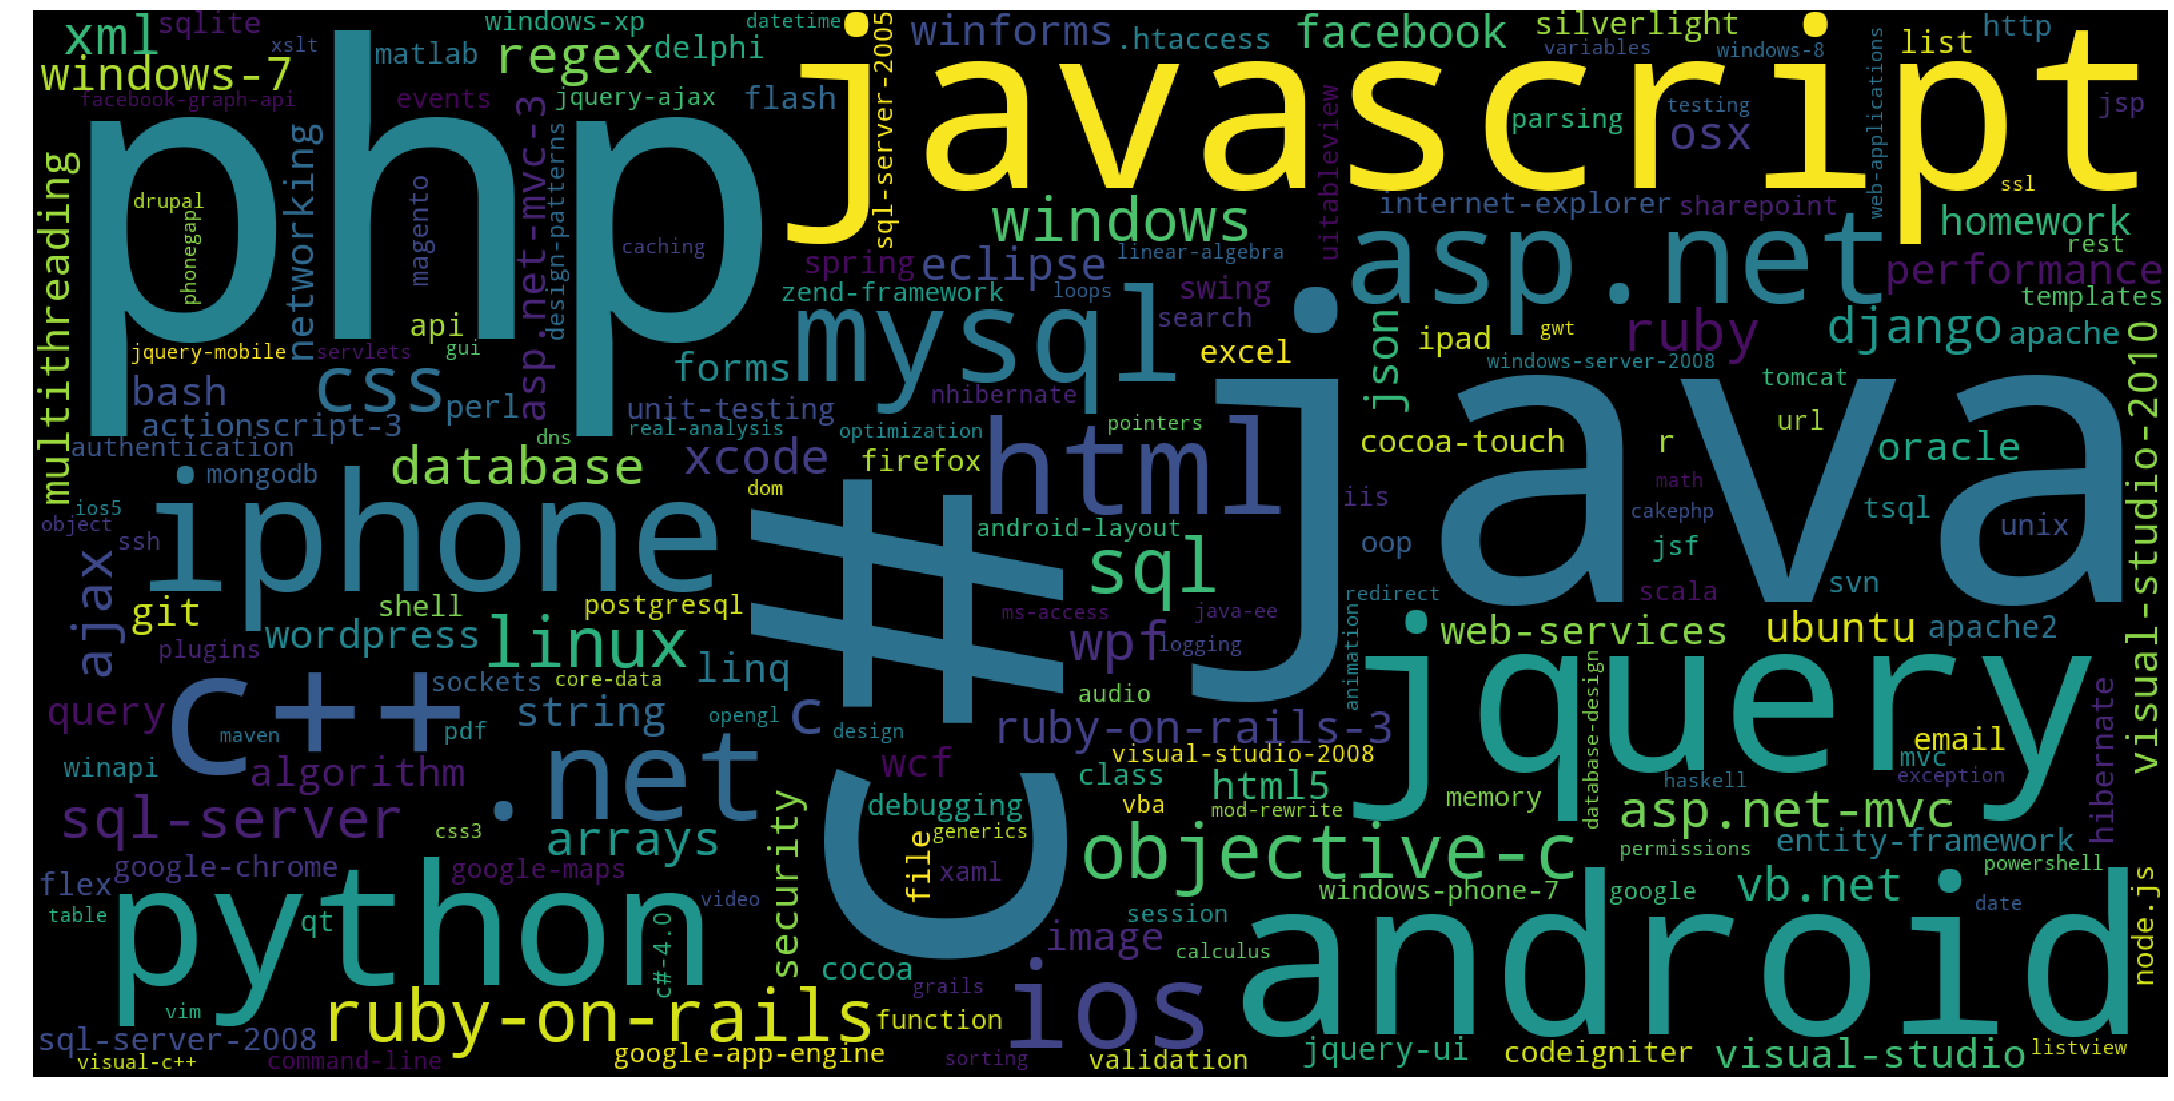

Time taken to run this cell : 0:00:03.175178


In [27]:
# PLotting Word Cloud

start = datetime.now()

# Convert the 'result' dictionary to list of tuples
tup = dict(result.items())

# Initaliazing wordcloud using frequency of tags
wordcloud = WordCloud(background_color='black',width=1600,height=800).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

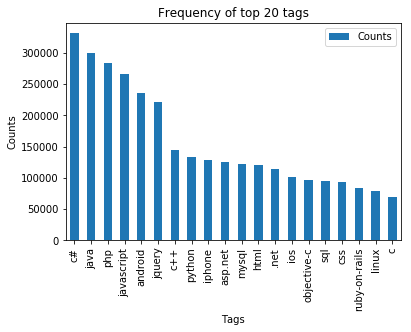

In [28]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 0.5M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [29]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [30]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()
    
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)   
  

Tables in the databse:
QuestionsProcessed


In [31]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500006;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:03:38.401816


we create a new data base to store the sampled and preprocessed questions.

In [32]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
import nltk
nltk.download('punkt')
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
        
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    x = len(question)+len(title)+len(title)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question= str(title)+" "+str(title)+" "+str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question except for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(3time's Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(3time's Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nrtsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(3time's Title+Body) before processing: 1272
Avg. length of questions(3time's Title+Body) after processing: 397
Percent of questions containing code: 57
Time taken to run this cell : 0:12:08.431695


In [33]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [34]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT question FROM QuestionsProcessed LIMIT 5")
        print("Questions after preprocessed")
        print("*"*100)
        # fetchone() returns one record as a tuple, If there are no more records then it returns None
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)

conn_r.commit()
conn_r.close()

Questions after preprocessed
****************************************************************************************************
('timertask thread timertask thread timertask thread differ timertask thread java groovi',)
----------------------------------------------------------------------------------------------------
('mysql describ output explan mysql describ output explan mysql describ output explan mysql tabl generat activerecord pleas explain meant tinyint second column accord mysql document size tinyint one byte mean take actual byte store data code generat second column like thank',)
----------------------------------------------------------------------------------------------------
('sysout show output execut piec code sysout show output execut piec code sysout show output execut piec code execut code time result output time pleas help get rid',)
----------------------------------------------------------------------------------------------------
('getclass getresourceasstrea

In [35]:
# #Taking half Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""",conn_r)
conn_r.commit()
conn_r.close()

In [36]:
preprocessed_data.head()

,question,tags
0,font problem pdftex font problem pdftex font p...,fonts pdftex
1,timertask thread timertask thread timertask th...,java groovy
2,mysql describ output explan mysql describ outp...,mysql table describe
3,sysout show output execut piec code sysout sho...,java ssh
4,getclass getresourceasstream maven project get...,maven resources


In [37]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500005
number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [38]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary = 'true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

As we have around 42k tags, processing of all the tags requires high computing power. So Let's take only th tags which covers around 90% data

In [39]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [40]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

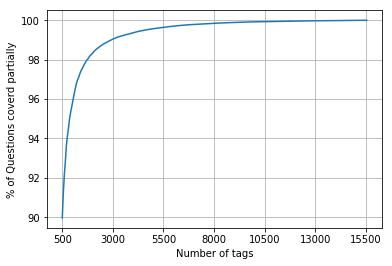

with  5500 tags we are covering  99.044 % of questions


In [41]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("% of Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [42]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 50147 out of  500005


<h2>4.2 Split the data into test and train (80:20) </h2>

In [43]:
total_size = preprocessed_data.shape[0]
train_size = int(0.8 * total_size)

x_train = preprocessed_data[:train_size]
x_test = preprocessed_data[train_size:]
y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [44]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400004, 2) (400004, 500)
(100001, 2) (100001, 500)


In [45]:
x_train.head(2)

,question,tags
0,font problem pdftex font problem pdftex font p...,fonts pdftex
1,timertask thread timertask thread timertask th...,java groovy


<h2>4.3 Featurizing data </h2>

In [56]:
start = datetime.now()
vectorizer = CountVectorizer(min_df = 0.00009, max_features = 20000, tokenizer = lambda x: x.split(), ngram_range = (1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("TIme taken to run this cell: ",datetime.now()-start)


TIme taken to run this cell:  0:06:14.227584


In [58]:
print(x_train_multilabel.shape, y_train.shape)
print(x_test_multilabel.shape, y_test.shape)

(400004, 20000) (400004, 500)
(100001, 20000) (100001, 500)


# Logistic Regression with OneVsRest Classifier

In [60]:
OneVsRestClassifier(LogisticRegression()).get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [61]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

params = {'estimator__C' : [10**i for i in range(-3,4)] }
clf_lr = OneVsRestClassifier(LogisticRegression())
clf_grid = GridSearchCV(clf_lr, params, cv = 3, n_jobs=-1)
clf_grid.fit(x_train_multilabel, y_train)
print(clf_grid.best_params_)
print("Time taken to run this cell: ",datetime.now()-start)


C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packa

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'estimator__C': 0.1}
Time taken to run this cell:  1 day, 15:09:53.662116


In [66]:
clf_grid

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='warn',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                                                                        r

In [67]:
# clf_lr = clf_grid.best_params_
clf_lr = OneVsRestClassifier(LogisticRegression(C = 1.0))
clf_lr.fit(x_train_multilabel, y_train)
predictions = clf_lr.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packa

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packa

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packa

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packa

Accuracy : 0.22112778872211278
Hamming loss  0.003045569544304557
Micro-average quality numbers
Precision: 0.6190, Recall: 0.4027, F1-measure: 0.4879
Macro-average quality numbers
Precision: 0.4741, Recall: 0.3267, F1-measure: 0.3836
              precision    recall  f1-score   support

           0       0.64      0.32      0.43      7790
           1       0.79      0.47      0.59      7093
           2       0.83      0.58      0.68      6788
           3       0.73      0.47      0.57      6318
           4       0.94      0.81      0.87      5616
           5       0.83      0.67      0.74      5261
           6       0.67      0.39      0.49      3387
           7       0.87      0.65      0.75      3201
           8       0.63      0.45      0.52      3055
           9       0.75      0.47      0.58      3021
          10       0.86      0.64      0.73      2849
          11       0.54      0.23      0.33      2904
          12       0.50      0.16      0.24      2684
         

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [69]:
import joblib
joblib.dump(clf_lr, 'lr_with_more_title_weight.pkl')

['lr_with_more_title_weight.pkl']

# Linear SVM with OneVsRest Classifer

In [70]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)


Accuracy : 0.12804871951280486
Hamming loss  0.004686053139468605
Micro-average quality numbers
Precision: 0.3758, Recall: 0.4546, F1-measure: 0.4115
Macro-average quality numbers
Precision: 0.2723, Recall: 0.3830, F1-measure: 0.3152
              precision    recall  f1-score   support

           0       0.46      0.41      0.43      7790
           1       0.58      0.55      0.56      7093
           2       0.66      0.61      0.63      6788
           3       0.56      0.49      0.52      6318
           4       0.83      0.83      0.83      5616
           5       0.71      0.69      0.70      5261
           6       0.46      0.44      0.45      3387
           7       0.69      0.72      0.70      3201
           8       0.51      0.48      0.50      3055
           9       0.54      0.49      0.51      3021
          10       0.67      0.67      0.67      2849
          11       0.33      0.29      0.31      2904
          12       0.26      0.21      0.23      2684
         

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# Logistic Regression with l1 penalty

In [71]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\j

Accuracy : 0.21548784512154878
Hamming loss  0.0031278487215127848
Micro-average quality numbers
Precision: 0.5932, Recall: 0.4203, F1-measure: 0.4920
Macro-average quality numbers
Precision: 0.4551, Recall: 0.3491, F1-measure: 0.3925
              precision    recall  f1-score   support

           0       0.60      0.36      0.45      7790
           1       0.74      0.50      0.59      7093
           2       0.79      0.58      0.67      6788
           3       0.70      0.47      0.57      6318
           4       0.91      0.81      0.86      5616
           5       0.82      0.67      0.74      5261
           6       0.60      0.41      0.49      3387
           7       0.82      0.67      0.74      3201
           8       0.63      0.45      0.53      3055
           9       0.71      0.47      0.57      3021
          10       0.79      0.65      0.71      2849
          11       0.47      0.27      0.34      2904
          12       0.44      0.18      0.26      2684
        

C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\nrtsa\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# Complete process


1.	Our data has Id, Title, Body and Tags
2.	So, based on the question our task is to predict tags
3.	Initially, we have done the Exploratory Data Analysis on the data and removed the duplicates and dropped the null values
4.	We have also done EDA on the tags and found out the top most used tags and plotted wordcloud
5.	Next step is preprocessing where we removed the code, special characters from title and Question, removed stop words except c, html tags and finally done the stemming.
6.	Now we need to create features from our data. So, we combined the title and body and applied Count Vectorizer. But here we have used a little hack that title was given more weight by repeating it 3 times. We get the features now.
7.	Next, we converted tags into multilabel using the Count Vectorizer. As we have around 42k tags which requires high computing power, so we have taken top 500 tags 
8.	Then we split the data into train and test
9.	And Finally, we applied Logistic Regression(with hypertuning) and Linear SVM with OnevsRest Classifier and computed the micro f1, macro f1 and hamming loss.


References:
Multi-label: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

OnevsRest: 
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

Performance metrics: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html 





# Results

In [72]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Micro F-1 Score", "Macro F-1 Score", "Hamming loss"]

x.add_row(["Logistic Regression with OnevsRestClassifier", 0.4879, 0.3836, 0.00304])
x.add_row(["linear SVM with OnevsRestClassifier", 0.4115, 0.3152, 0.0046])
x.add_row(["Logistic Regression with OnevsRestClassifier (l1 penalty)", 0.4920, 0.3925, 0.00312])

print(x)

+-----------------------------------------------------------+-----------------+-----------------+--------------+
|                           Model                           | Micro F-1 Score | Macro F-1 Score | Hamming loss |
+-----------------------------------------------------------+-----------------+-----------------+--------------+
|        Logistic Regression with OnevsRestClassifier       |      0.4879     |      0.3836     |   0.00304    |
|            linear SVM with OnevsRestClassifier            |      0.4115     |      0.3152     |    0.0046    |
| Logistic Regression with OnevsRestClassifier (l1 penalty) |      0.492      |      0.3925     |   0.00312    |
+-----------------------------------------------------------+-----------------+-----------------+--------------+
